In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import integrate
from scipy import interpolate
from scipy import linalg
from scipy import sparse
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,inputs,network,connectivity,dynamics_np,probe_RFs
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2024-03-31 23:07:09.789670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Build two-layer system

In [25]:
reload(uf)

cname = 'lempel_huge_model'

cdict,N4pop,Nlgnpop,Nret,Nlgn,N4,N23,rA = uf.get_two_layer_network_size(cname)

filename = "two_layer/{s}/v{v}/config_v{v}".format(s=cname,v=-1)
misc.save_params(-1,filename,cdict)

MISC params_dict params_lempel_huge_model {'Nret': 80, 'Nlgn': 80, 'N4': 80, 'N23': 80, 'Nvert': 1, 'runtime': 20000, 'dt': 1.0, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10000, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 20, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'gabor_patch_rect', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.001, 'sigma2': 1.0, 'ampl1': 1.0, 'ampl2': 0.0, 'gamma_ret': 1.0, 'noise': 0.0, 'profile': 'Mexican-hat'}, 'Wlgn_to4_params': {'sigma': 0.2, 'ampl': 1.0, 'noise': 0

In [16]:
reload(uf)

WRtoT,_ = connectivity.Connectivity((Nret*3//4,Nret*3//4),(Nlgn*3//4,Nlgn*3//4),\
                    random_seed=cdict["random_seed"],Nvert=1, verbose=False).create_matrix(\
                    cdict["Wret_to_lgn_params"],\
                    cdict["Wret_to_lgn_params"]["profile"])
WRtoT *= cdict["Wret_to_lgn_params"]["gamma_ret"]

conn2pop = connectivity.Connectivity_2pop((N4*3//4,N4*3//4),(N4*3//4,N4*3//4),\
                                    (N4*3//4,N4*3//4), (N4*3//4,N4*3//4),\
                                        random_seed=cdict["random_seed"],\
                                        Nvert=1, verbose=False)
W4to4,_ = conn2pop.create_matrix_2pop(cdict["W4to4_params"],cdict["W4to4_params"]["Wrec_mode"])

conn2pop = connectivity.Connectivity_2pop((N23*3//4,N23*3//4),(N23*3//4,N23*3//4),\
                                    (N23*3//4,N23*3//4), (N23*3//4,N23*3//4),\
                                        random_seed=cdict["random_seed"],\
                                        Nvert=1, verbose=False)
W23to23,_ = conn2pop.create_matrix_2pop(cdict["W23_params"],cdict["W23_params"]["Wrec_mode"])

conn2pop = connectivity.Connectivity_2pop((N4*3//4,N4*3//4),(N4*3//4,N4*3//4),\
                                    (N23*3//4,N23*3//4), (N23*3//4,N23*3//4),\
                                        random_seed=cdict["random_seed"],\
                                        Nvert=1, verbose=False)
W4to23,_ = conn2pop.create_matrix_2pop(cdict["W4to23_params"],cdict["W4to23_params"]["Wrec_mode"])

# WRtoT,WTto4,AN,AF,ATto4,_,W4to4,A4to4,W23to23,A23to23,W4to23,A4to23,_,W23to4 = uf.get_two_layer_network_system(-1,cname)

{'sigma_EE': 0.02375, 'sigma_IE': 0.02375, 'sigma_EI': 0.0175, 'sigma_II': 0.0075, 'aEE': 22.2, 'aIE': 21.6, 'aEI': 21.6, 'aII': 20.8, 'noise': 0, 'rA_EE': 0.07125, 'rA_IE': 0.07125, 'rA_EI': 0.0525, 'rA_II': 0.0225, 'ampl_EE': 1.0, 'ampl_IE': 1.0, 'ampl_EI': 1.0, 'ampl_II': 1.0, 'arbor_profile_EE': 'heaviside', 'arbor_profile_IE': 'heaviside', 'arbor_profile_EI': 'heaviside', 'arbor_profile_II': 'heaviside', 'r_lim': 1.0, 'Wrec_mode': 'Gaussian2pop', 'sigma_factor': 1.3333333, 'max_ew': 0.4, 'density': 0.5, 'ncluster': 3, 'nu_4': 3.0, 'beta_P': 0.0005, 'Wlim': 200, 'learning_rate': 0.5, 'plasticity_rule': 'None', 'constraint_mode': 'None', 'mult_norm': 'None', 'firing_threshold': 'adaptive', 'theta_4': 0.9, 'l4_avg': 0.0}
{'sigma_EE': 0.02375, 'sigma_IE': 0.02375, 'sigma_EI': 0.0175, 'sigma_II': 0.0075, 'aEE': 22.2, 'aIE': 21.6, 'aEI': 21.6, 'aII': 20.8, 'noise': 0, 'rA_EE': 0.07125, 'rA_IE': 0.07125, 'rA_EI': 0.0525, 'rA_II': 0.0225, 'ampl_EE': 1.0, 'ampl_IE': 1.0, 'ampl_EI': 1.0, 'a

Text(0.5, 1.0, 'Ret Cell (Pre)')

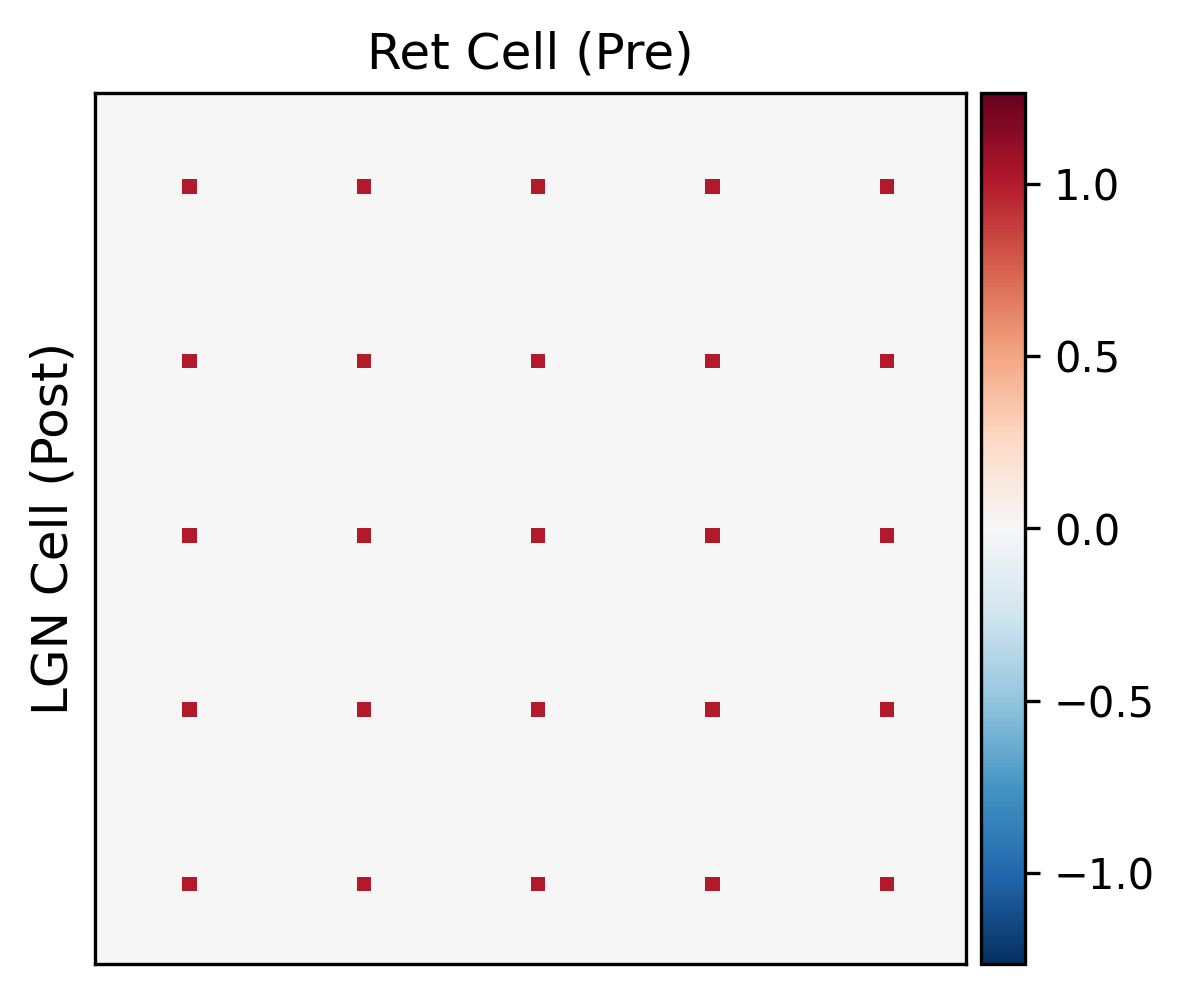

In [5]:
fig,axs = plt.subplots(1,1,figsize=(4,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WTR = np.zeros((N4*3//4,N4*3//4))

idxs = np.arange(N4*3//4//10,N4*3//4,N4*3//4//5)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N4*3//4,N4*3//4))
        WTR += WRtoT[:(N4*3//4)**2,:(N4*3//4)**2][:,rav_idx].reshape(N4*3//4,N4*3//4)

pf.imshowbar(fig,axs,WTR,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')

axs.set_ylabel('LGN Cell (Post)',fontsize=12)
axs.set_title('Ret Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(W4to4,1,which='LR')
# print(eigval)

Text(0.5, 1.0, 'L4 I Cell (Pre)')

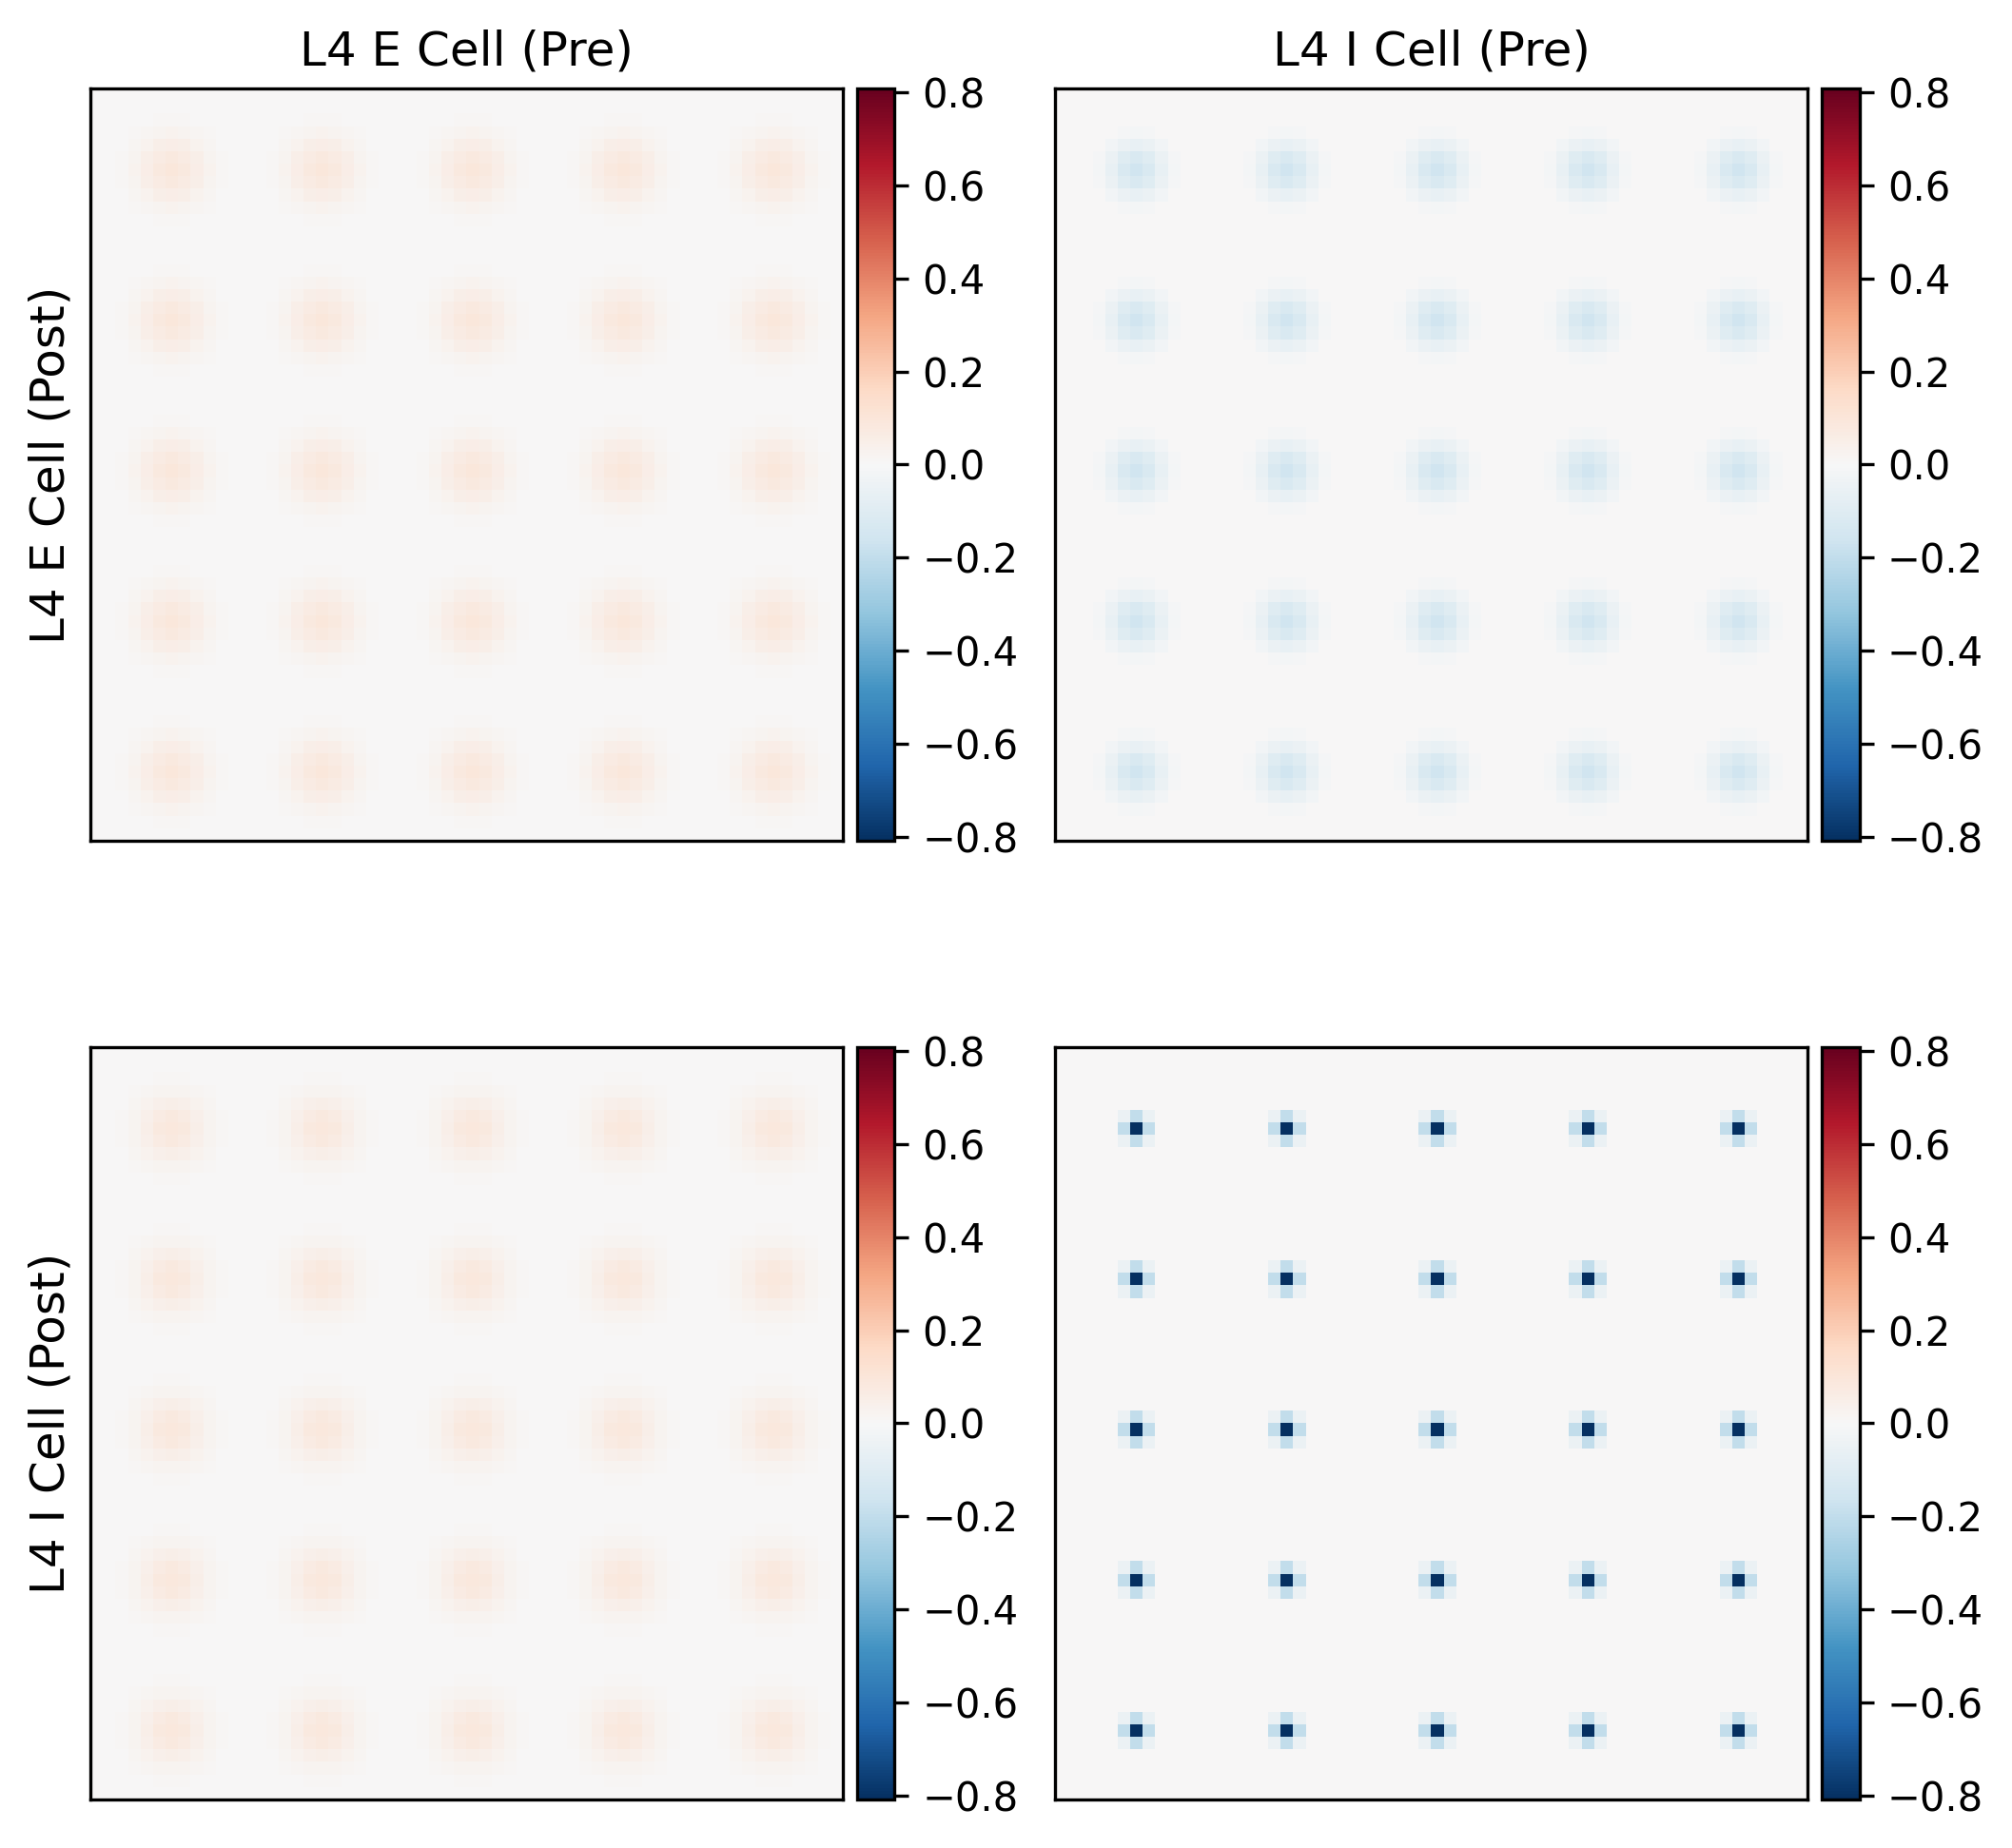

In [17]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WEE = np.zeros((N4*3//4,N4*3//4))
WEI = np.zeros((N4*3//4,N4*3//4))
WIE = np.zeros((N4*3//4,N4*3//4))
WII = np.zeros((N4*3//4,N4*3//4))

idxs = np.arange(N4*3//4//10,N4*3//4,N4*3//4//5)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N4*3//4,N4*3//4))
        WEE += W4to4[:(N4*3//4)**2,:(N4*3//4)**2][:,rav_idx].reshape(N4*3//4,N4*3//4)
        WEI += W4to4[:(N4*3//4)**2,(N4*3//4)**2:][:,rav_idx].reshape(N4*3//4,N4*3//4)
        WIE += W4to4[(N4*3//4)**2:,:(N4*3//4)**2][:,rav_idx].reshape(N4*3//4,N4*3//4)
        WII += W4to4[(N4*3//4)**2:,(N4*3//4)**2:][:,rav_idx].reshape(N4*3//4,N4*3//4)

pf.imshowbar(fig,axs[0,0],WEE,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],WEI,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],WIE,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],WII,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')

axs[0,0].set_ylabel('L4 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L4 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L4 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L4 I Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(W4to4,1,which='LR')
# print(eigval)

Text(0.5, 1.0, 'L2/3 I Cell (Pre)')

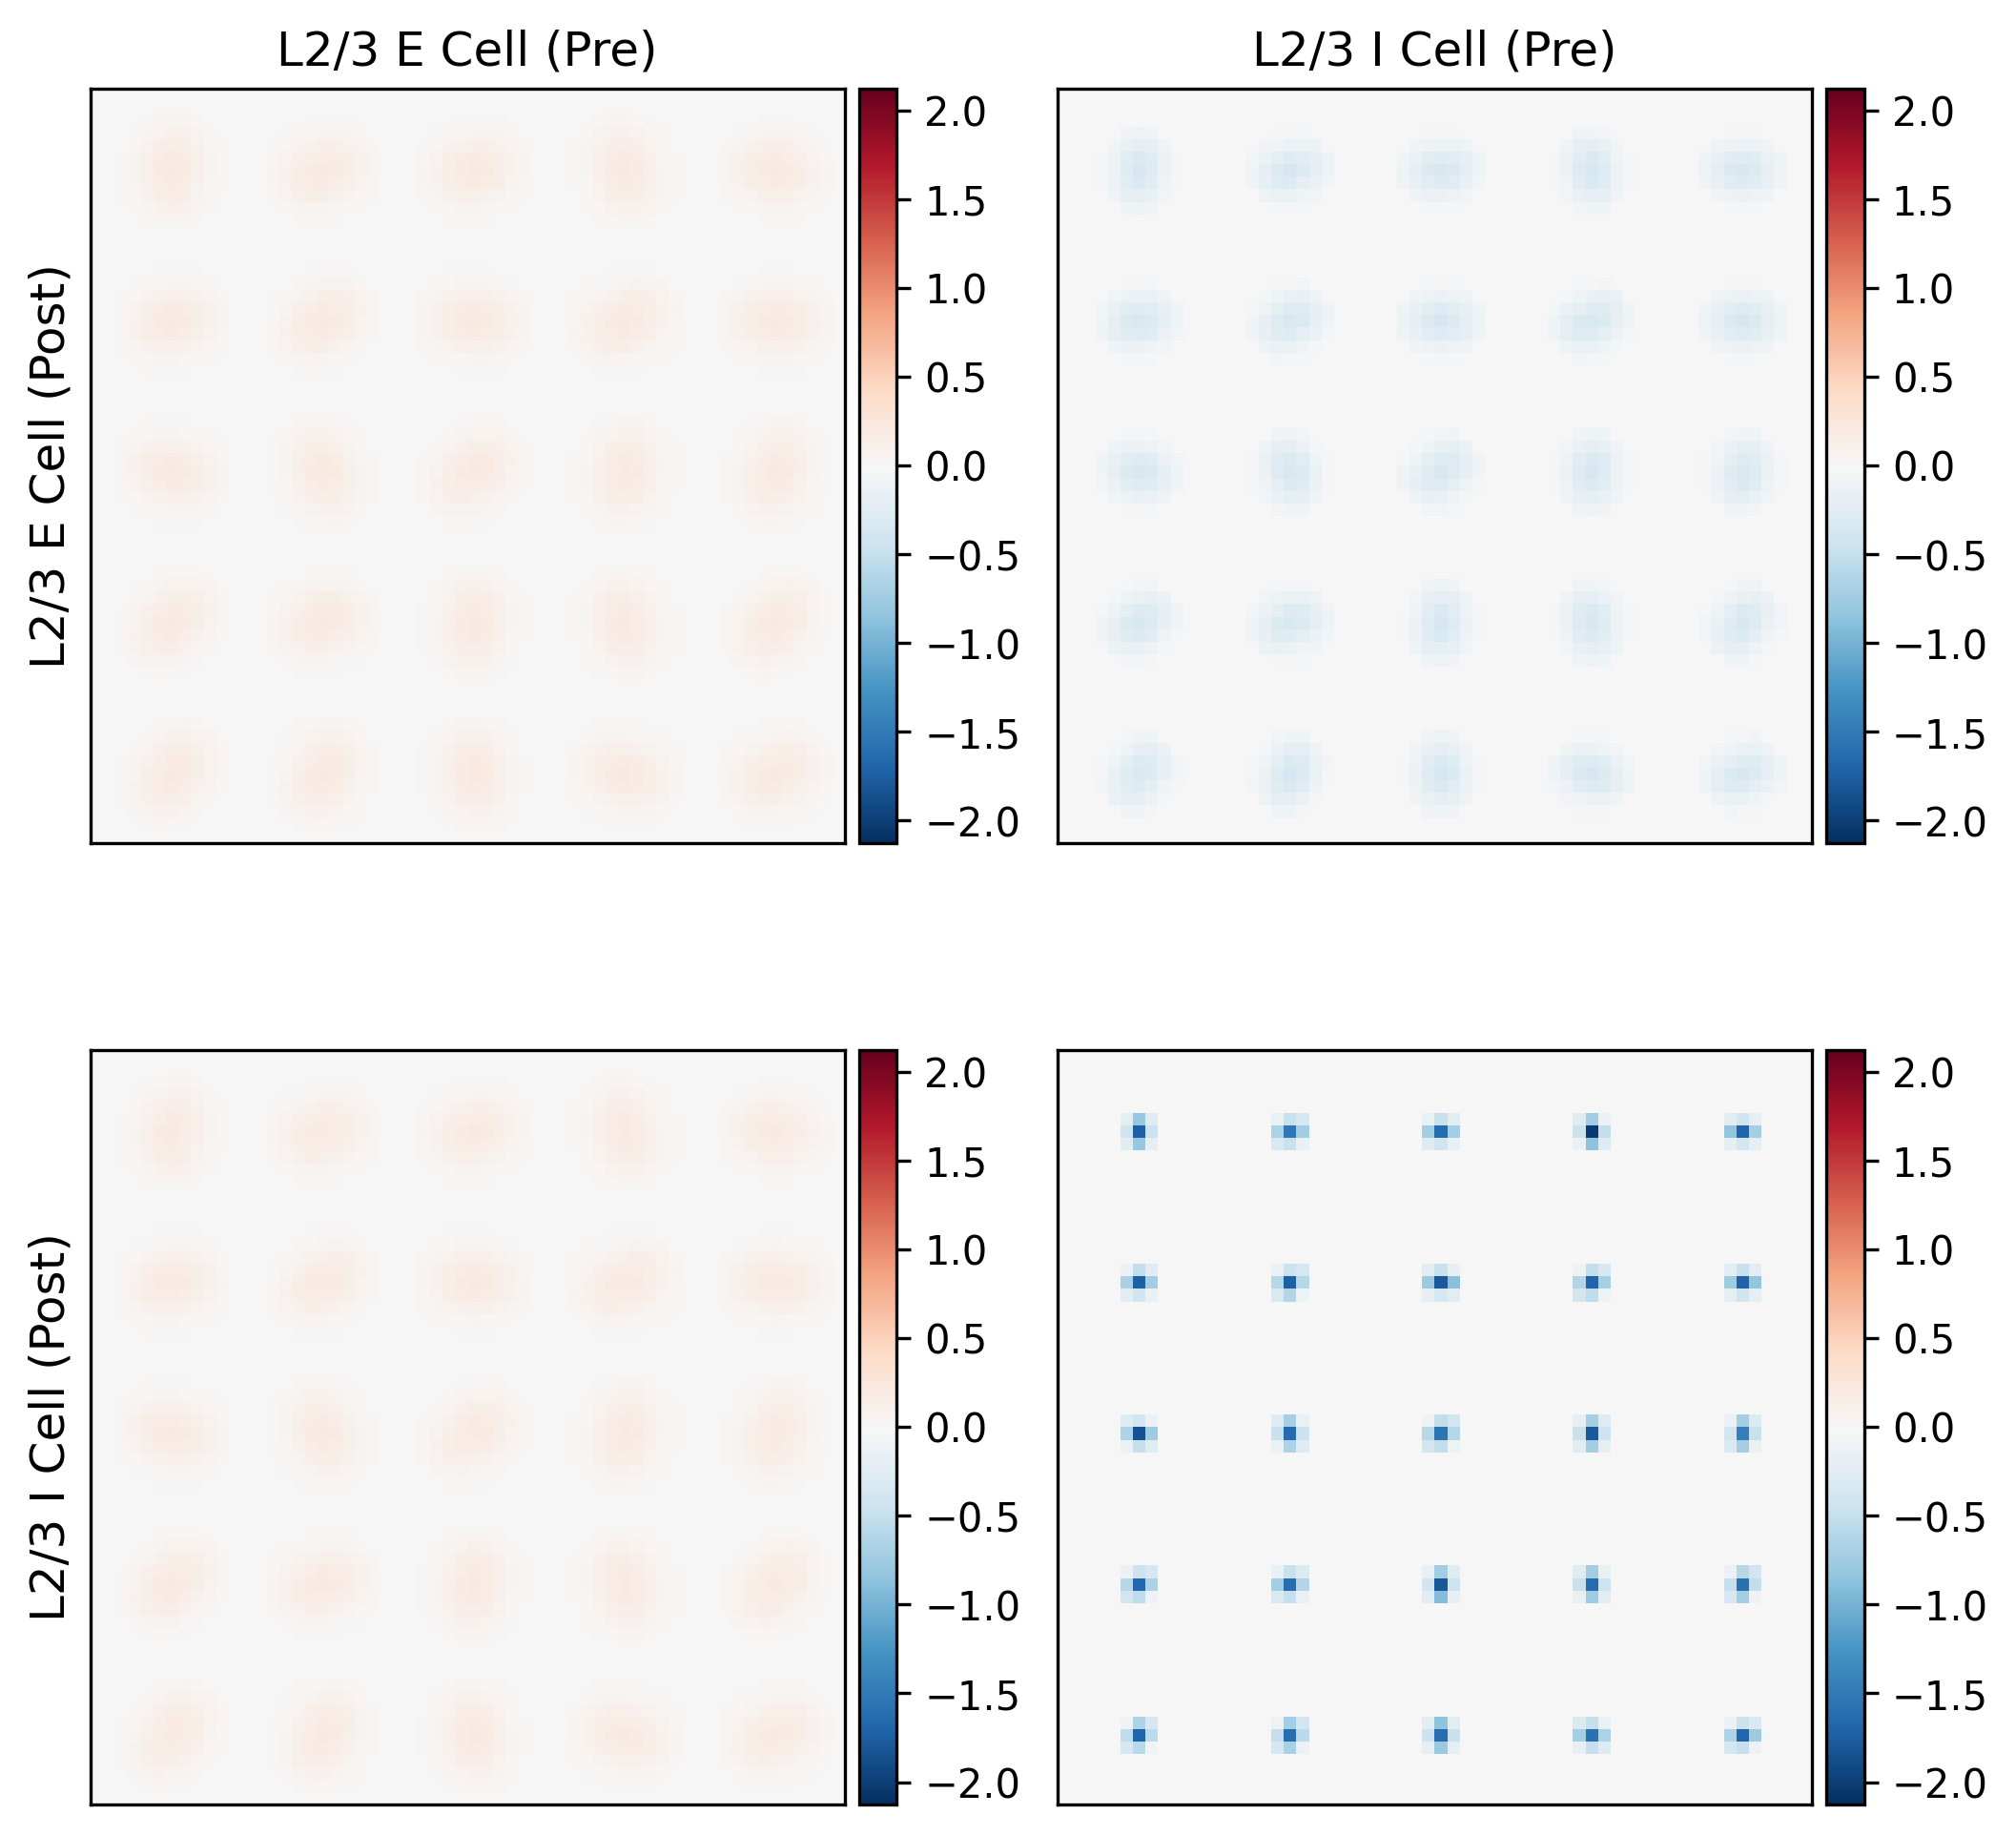

In [18]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WEE = np.zeros((N4*3//4,N4*3//4))
WEI = np.zeros((N4*3//4,N4*3//4))
WIE = np.zeros((N4*3//4,N4*3//4))
WII = np.zeros((N4*3//4,N4*3//4))

idxs = np.arange(N4*3//4//10,N4*3//4,N4*3//4//5)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N4*3//4,N4*3//4))
        WEE += W23to23[:(N4*3//4)**2,:(N4*3//4)**2][:,rav_idx].reshape(N4*3//4,N4*3//4)
        WEI += W23to23[:(N4*3//4)**2,(N4*3//4)**2:][:,rav_idx].reshape(N4*3//4,N4*3//4)
        WIE += W23to23[(N4*3//4)**2:,:(N4*3//4)**2][:,rav_idx].reshape(N4*3//4,N4*3//4)
        WII += W23to23[(N4*3//4)**2:,(N4*3//4)**2:][:,rav_idx].reshape(N4*3//4,N4*3//4)

pf.imshowbar(fig,axs[0,0],WEE,
            vmin=-np.max(np.abs(W23to23)),vmax=np.max(np.abs(W23to23)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],WEI,
            vmin=-np.max(np.abs(W23to23)),vmax=np.max(np.abs(W23to23)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],WIE,
            vmin=-np.max(np.abs(W23to23)),vmax=np.max(np.abs(W23to23)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],WII,
            vmin=-np.max(np.abs(W23to23)),vmax=np.max(np.abs(W23to23)),cmap='RdBu_r')

axs[0,0].set_ylabel('L2/3 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L2/3 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L2/3 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L2/3 I Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(W4to4,1,which='LR')
# print(eigval)

Text(0.5, 1.0, 'L4 I Cell (Pre)')

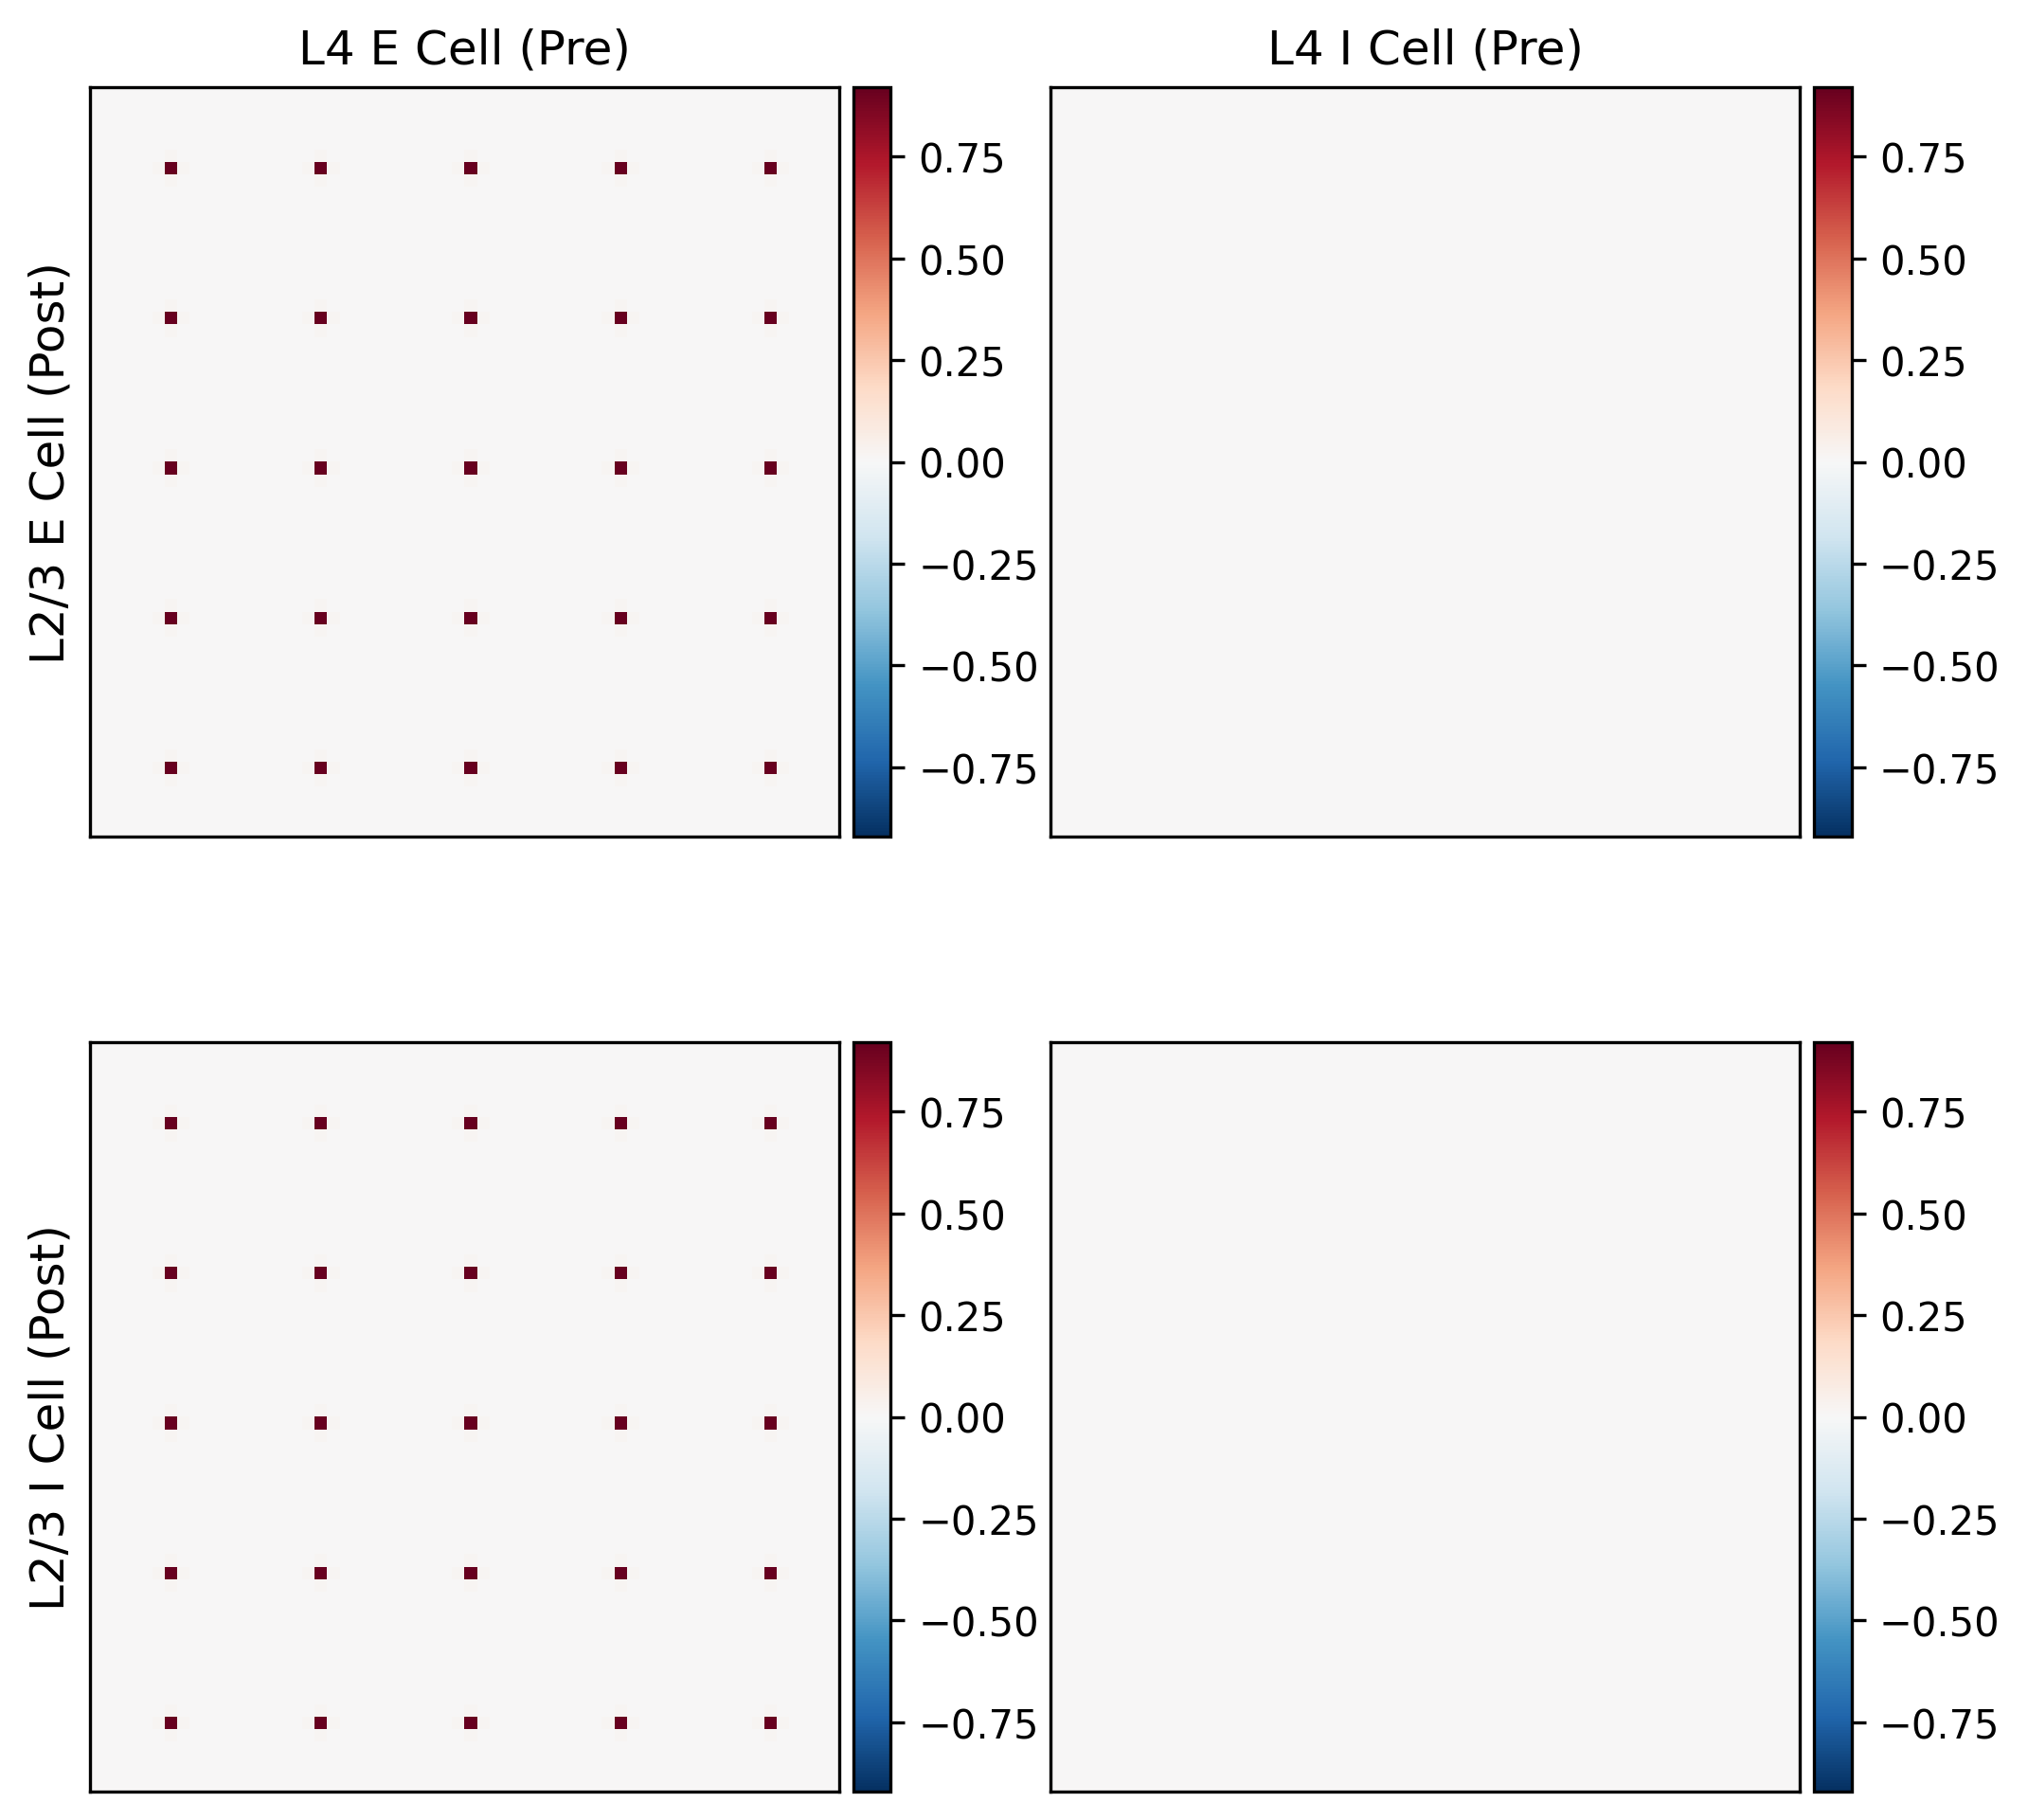

In [27]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WEE = np.zeros((N4*3//4,N4*3//4))
WEI = np.zeros((N4*3//4,N4*3//4))
WIE = np.zeros((N4*3//4,N4*3//4))
WII = np.zeros((N4*3//4,N4*3//4))

idxs = np.arange(N4*3//4//10,N4*3//4,N4*3//4//5)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N4*3//4,N4*3//4))
        WEE += W4to23[:(N4*3//4)**2,:(N4*3//4)**2][:,rav_idx].reshape(N4*3//4,N4*3//4)
        WEI += W4to23[:(N4*3//4)**2,(N4*3//4)**2:][:,rav_idx].reshape(N4*3//4,N4*3//4)
        WIE += W4to23[(N4*3//4)**2:,:(N4*3//4)**2][:,rav_idx].reshape(N4*3//4,N4*3//4)
        WII += W4to23[(N4*3//4)**2:,(N4*3//4)**2:][:,rav_idx].reshape(N4*3//4,N4*3//4)

pf.imshowbar(fig,axs[0,0],WEE,
            vmin=-np.max(np.abs(W4to23)),vmax=np.max(np.abs(W4to23)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],WEI,
            vmin=-np.max(np.abs(W4to23)),vmax=np.max(np.abs(W4to23)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],WIE,
            vmin=-np.max(np.abs(W4to23)),vmax=np.max(np.abs(W4to23)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],WII,
            vmin=-np.max(np.abs(W4to23)),vmax=np.max(np.abs(W4to23)),cmap='RdBu_r')

axs[0,0].set_ylabel('L2/3 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L2/3 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L4 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L4 I Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(W4to4,1,which='LR')
# print(eigval)

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_76756/671801372.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(WEE))


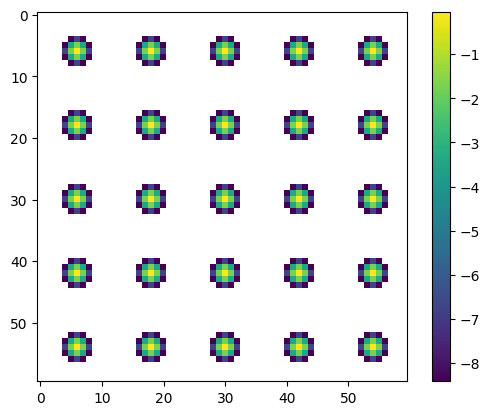

In [28]:
plt.imshow(np.log10(WEE))
plt.colorbar()

In [23]:
xs,ys = np.meshgrid(np.arange(N4)/N4,np.arange(N4)/N4)
dxs = np.abs(xs[:,:,None,None] - xs[None,None,:,:])
dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
dys = np.abs(ys[:,:,None,None] - ys[None,None,:,:])
dys[dys > 0.5] = 1 - dys[dys > 0.5]
ds2 = dxs**2 + dys**2
ds = np.sqrt(ds2)

Wlker = 0.6*0.0075
Wlker2 = Wlker**2

if Wlker != 0.0:
    W = np.exp(-0.5*ds2/Wlker2)
else:
    W = (ds2 == 0.0).astype(float)
    
# W *= np.random.default_rng(0).random((N4,N4,N4,N4))
    
W /= np.sum(W,(-2,-1))[:,:,None,None]

In [24]:
W

array([[[[9.20622184e-01, 1.94340180e-02, 1.82812588e-07, ...,
          7.66323114e-16, 1.82812588e-07, 1.94340180e-02],
         [1.94340180e-02, 4.10245444e-04, 3.85911094e-09, ...,
          1.61768177e-17, 3.85911094e-09, 4.10245444e-04],
         [1.82812588e-07, 3.85911094e-09, 3.63020173e-14, ...,
          1.52172644e-22, 3.63020173e-14, 3.85911094e-09],
         ...,
         [7.66323114e-16, 1.61768177e-17, 1.52172644e-22, ...,
          6.37885037e-31, 1.52172644e-22, 1.61768177e-17],
         [1.82812588e-07, 3.85911094e-09, 3.63020173e-14, ...,
          1.52172644e-22, 3.63020173e-14, 3.85911094e-09],
         [1.94340180e-02, 4.10245444e-04, 3.85911094e-09, ...,
          1.61768177e-17, 3.85911094e-09, 4.10245444e-04]],

        [[1.94340180e-02, 9.20622184e-01, 1.94340180e-02, ...,
          1.43146286e-27, 7.66323114e-16, 1.82812588e-07],
         [4.10245444e-04, 1.94340180e-02, 4.10245444e-04, ...,
          3.02176891e-29, 1.61768177e-17, 3.85911094e-09],
        

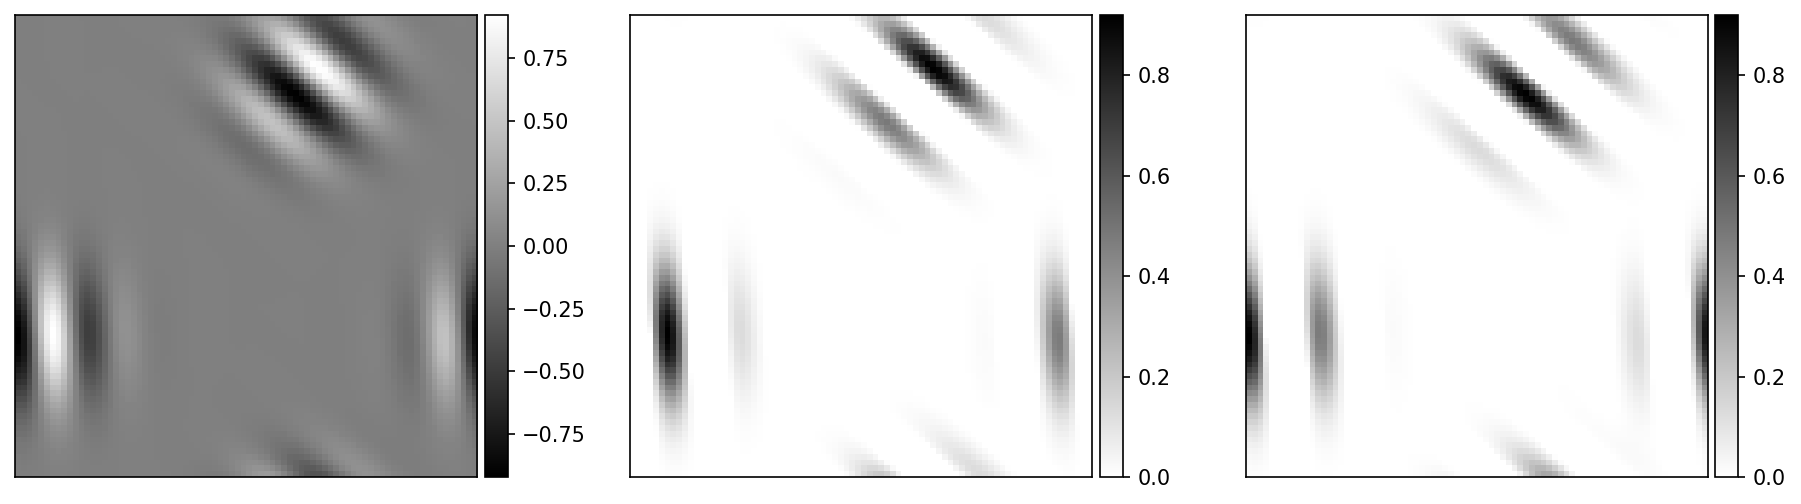

In [8]:
reload(inputs)

rng = np.random.default_rng(0)

ret = inputs.gabor_patch(80,rng.integers(80),rng.integers(80),np.pi*rng.random())+\
    inputs.gabor_patch(80,rng.integers(80),rng.integers(80),np.pi*rng.random())
on = np.fmax(0,ret)
of = np.fmax(0,-ret)

fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=150)

pf.imshowbar(fig,axs[0],ret,origin='lower',cmap='binary_r')
pf.imshowbar(fig,axs[1],on,origin='lower',cmap='binary')
pf.imshowbar(fig,axs[2],of,origin='lower',cmap='binary')

In [3]:
from scipy.stats import qmc

xs,ys = np.meshgrid(np.arange(80)/80,np.arange(80)/80)
dxs = np.abs(xs[:,:,None,None] - xs[None,None,:,:])
dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
dys = np.abs(ys[:,:,None,None] - ys[None,None,:,:])
dys[dys > 0.5] = 1 - dys[dys > 0.5]
dists = dxs**2 + dys**2

def gen_maps(N,dens,bgnd_min,bgnd_max,maxOS,meanOS,seed,areaCV=0,arbor_fact=0.5,sel_pow=1.3):
    rng = np.random.default_rng(seed)
    
    bgndOS = 0.5*(bgnd_min+bgnd_max)

    nclstr = np.round(N**2*dens).astype(int)
    sig2 = (meanOS - bgndOS)/((maxOS - bgndOS)*dens*np.pi) / N**2

    rng = np.random.default_rng(seed)

    clstr_pts = qmc.Halton(d=2,scramble=False,seed=seed).random(nclstr)
    
    oris = 2*np.pi*rng.random(nclstr)
    
    if np.isclose(areaCV,0):
        sig2s = sig2*np.ones(nclstr)
        rng.gamma(shape=1,scale=1,size=nclstr)
    else:
        shape = 1/areaCV**2
        scale = sig2/shape
        sig2s = rng.gamma(shape=shape,scale=scale,size=nclstr)
    
    xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
    dxs = np.abs(xs[None,:,:] - clstr_pts[:,0,None,None])
    dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
    dys = np.abs(ys[None,:,:] - clstr_pts[:,1,None,None])
    dys[dys > 0.5] = 1 - dys[dys > 0.5]
    ds2s = dxs**2 + dys**2

    omap = np.zeros((N,N),dtype='complex64')
    holes = np.zeros((N,N),dtype='float64')
    
    for i in range(nclstr):
        omap += np.heaviside(1.01*sig2s[i]-ds2s[i],1)*np.exp(1j*oris[i])
        holes += np.heaviside(1.01*sig2s[i]-ds2s[i],1)
            
    true_clstr_size = np.sum(np.abs(omap))
    omap *= maxOS*nclstr*np.pi*sig2*N**2/true_clstr_size

    ks = np.arange(N)/N
    ks[ks > 0.5] = ks[ks > 0.5] - 1
    kxs,kys = np.meshgrid(ks*N,ks*N)

    bgnd_ofield = np.fft.ifft2(np.exp(-0.25*(kxs**2+kys**2)*sig2*16)*np.fft.fft2(np.exp(1j*2*np.pi*rng.random((N,N)))))
    bgnd_ofield /= np.abs(bgnd_ofield)
    bgnd_sfield = np.real(np.fft.ifft2(np.exp(-0.25*(kxs**2+kys**2)*sig2*16)*np.fft.fft2(rng.random((N,N)))))
    bgnd_sfield -= np.min(bgnd_sfield)
    bgnd_sfield *= (bgnd_max-bgnd_min) / (np.max(bgnd_sfield) - np.min(bgnd_sfield))
    bgnd_sfield += bgnd_min
    bgnd_sfield /= nclstr*np.pi*sig2*N**2/true_clstr_size
    bgnd_sfield = bgnd_min+(bgnd_max-bgnd_min)*rng.random((N,N))
    omap += bgnd_sfield*bgnd_ofield*(1-holes)

    gauss = np.exp(-0.5*dists/(sig2*arbor_fact**2))
    gauss *= np.abs(omap[None,None,:,:])**sel_pow
    gauss /= np.sum(gauss,(-2,-1))[:,:,None,None]

    imap = np.einsum('ijkl,kl->ij',gauss,omap)
    
    return omap,imap

In [20]:
dens = 0.01
bgnd_min = 0.05
bgnd_max = 0.25
meanOS = 0.17
maxOS = 0.5

omap,imap = gen_maps(80,dens,bgnd_min,bgnd_max,maxOS,meanOS,0)
sig2 = (meanOS - 0.5*(bgnd_min+bgnd_max))/((maxOS - 0.5*(bgnd_min+bgnd_max))*dens*np.pi) / 80**2

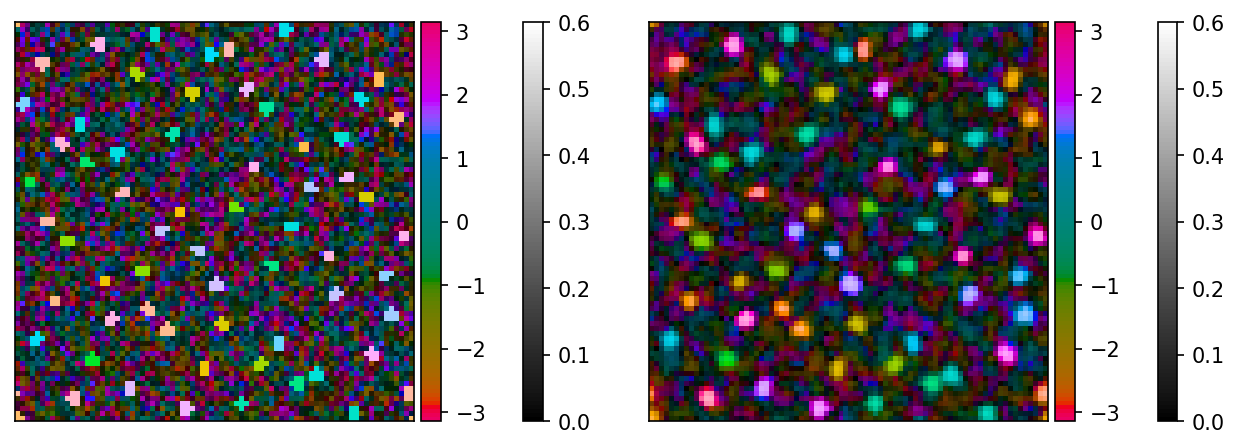

In [21]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)
pf.domcolbar(fig,axs[0],omap,rlim=(0,0.6),origin='lower')
pf.domcolbar(fig,axs[1],imap,rlim=(0,0.6),origin='lower')

In [18]:
dens = 1/500
bgnd_min = 0.05
bgnd_max = 0.25
meanOS = 0.17
maxOS = 0.5

omap,imap = gen_maps(80,dens,bgnd_min,bgnd_max,maxOS,meanOS,0)
sig2 = (meanOS - 0.5*(bgnd_min+bgnd_max))/((maxOS - 0.5*(bgnd_min+bgnd_max))*dens*np.pi) / 80**2

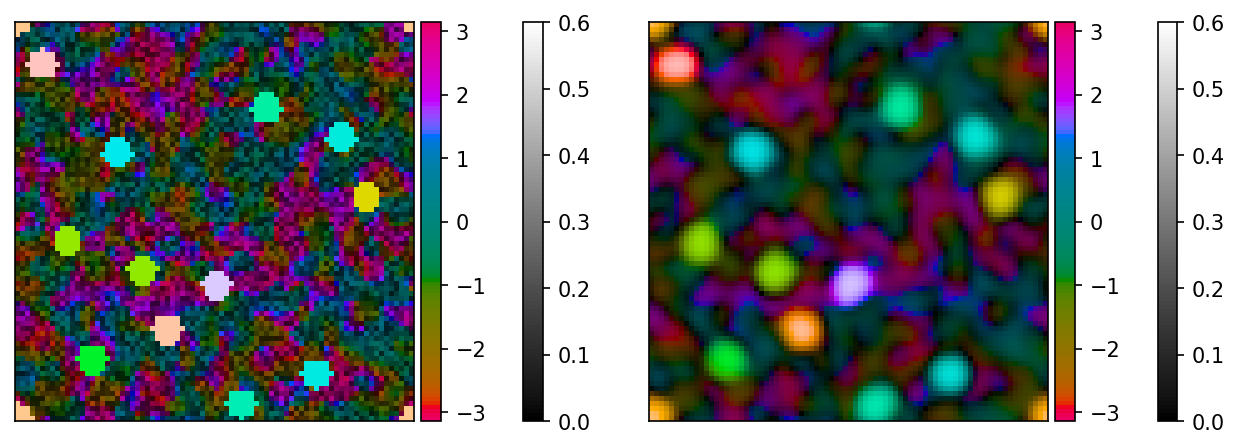

In [19]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)
pf.domcolbar(fig,axs[0],omap,rlim=(0,0.6),origin='lower')
pf.domcolbar(fig,axs[1],imap,rlim=(0,0.6),origin='lower')

In [6]:
dens = 1/500
bgnd_min = 0.05
bgnd_max = 0.25
meanOS = 0.17
maxOS = 0.5

omap,imap = gen_maps(80,dens,bgnd_min,bgnd_max,maxOS,meanOS,0,areaCV=0.3)

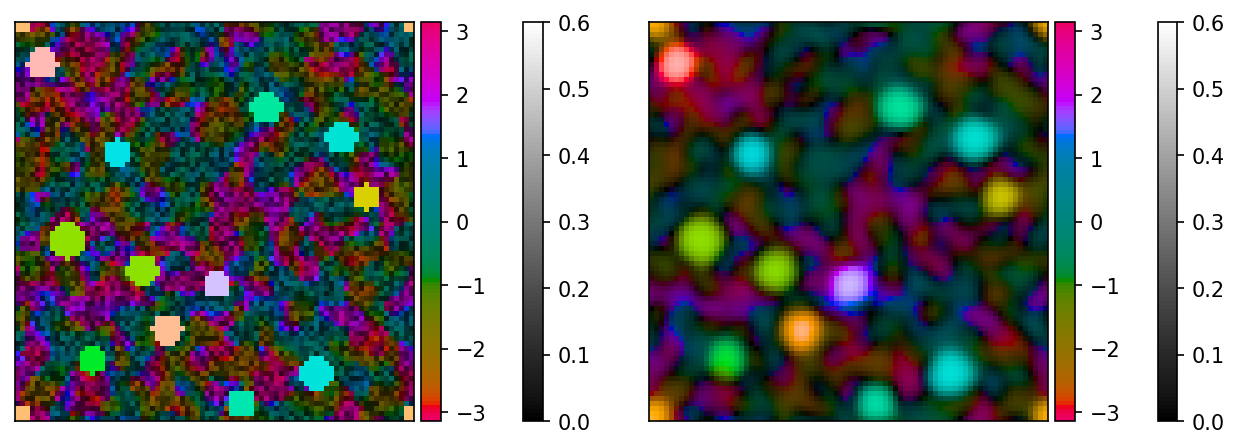

In [7]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)
pf.domcolbar(fig,axs[0],omap,rlim=(0,0.6),origin='lower')
pf.domcolbar(fig,axs[1],imap,rlim=(0,0.6),origin='lower')

Text(0.5, 1.0, 'FPS of Orientation Map')

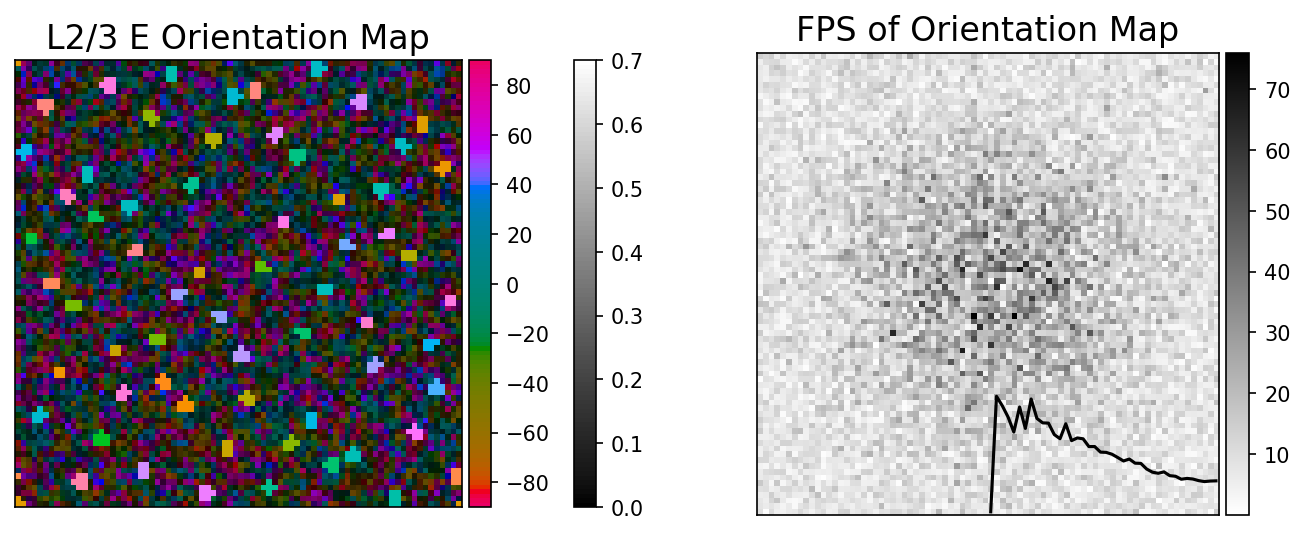

In [23]:
ori_fft = np.abs(np.fft.fftshift(np.fft.fft2(omap - np.nanmean(omap))))
ori_fps = np.zeros(80//2)

grid = np.arange(-80//2,80//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(80//2*np.sqrt(2)))+0.5)
for idx in range(80//2):
    ori_fps[idx] = np.mean(ori_fft[bin_idxs == idx])
    
fig,axs = plt.subplots(1,2,figsize=(11,4),dpi=150)

pf.domcolbar(fig,axs[0],omap,origin='lower',rlim=(0,0.7),alim=(-90,90))

pf.imshowbar(fig,axs[1],ori_fft,origin='lower',cmap='binary')
axs[1].plot(80//2+np.arange(80//2),ori_fps/np.max(ori_fps)*80/4,'k')

axs[0].set_title('L2/3 E Orientation Map',fontsize=16)
axs[1].set_title('FPS of Orientation Map',fontsize=16)

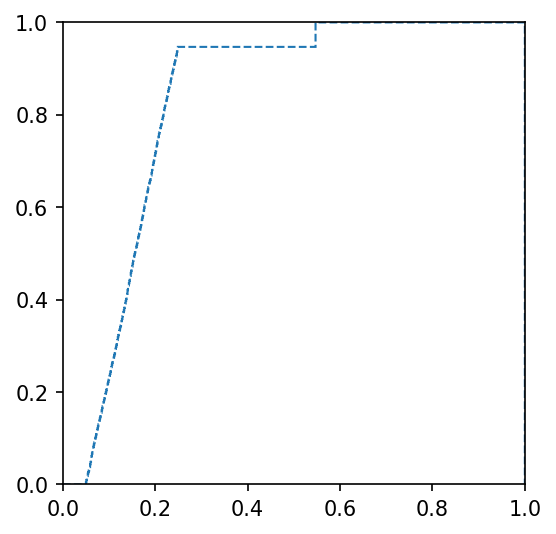

In [1285]:
fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)

ax.hist(np.abs(omap).flatten(),np.linspace(0,1,1001),density=True,cumulative=True,histtype='step',ls='--')
# ax.hist(np.abs(imap).flatten(),np.linspace(0,1,1001),density=True,cumulative=True,histtype='step',ls='--')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.savefig('./L4_cdf.pdf')

In [8]:
arbor_facts = 10**np.linspace(-2,0,7)
sel_pows = np.linspace(0,1.4,8)

omap_OS_mean = np.zeros((len(arbor_facts),len(sel_pows)))
imap_OS_mean = np.zeros((len(arbor_facts),len(sel_pows)))
omap_OS_std = np.zeros((len(arbor_facts),len(sel_pows)))
imap_OS_std = np.zeros((len(arbor_facts),len(sel_pows)))

for i,arbor_fact in enumerate(arbor_facts):
    for j,sel_pow in enumerate(sel_pows):
        omap,imap = gen_maps(80,dens,bgnd_min,bgnd_max,maxOS,meanOS,0,arbor_fact=arbor_fact,sel_pow=sel_pow)
        omap_OS_mean[i,j] = np.mean(np.abs(omap))
        imap_OS_mean[i,j] = np.mean(np.abs(imap))
        omap_OS_std[i,j] = np.std(np.abs(omap))
        imap_OS_std[i,j] = np.std(np.abs(imap))

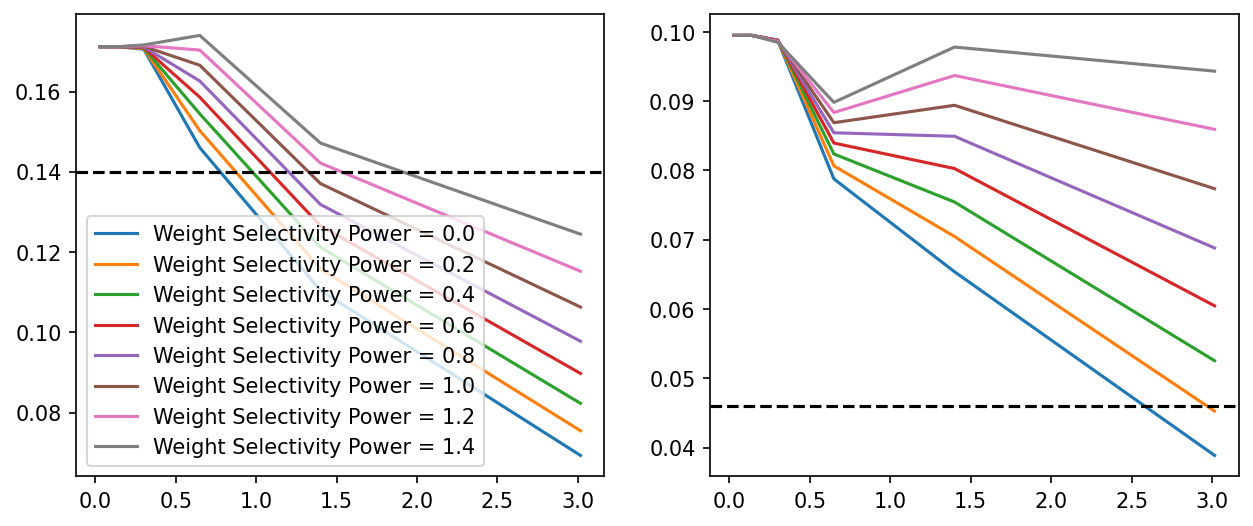

In [14]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)

for j,sel_pow in enumerate(sel_pows):
    axs[0].plot(arbor_facts*np.sqrt(sig2)*80,imap_OS_mean[:,j],label='Weight Selectivity Power = {:.1f}'.format(sel_pow))
    axs[1].plot(arbor_facts*np.sqrt(sig2)*80,imap_OS_std[:,j],label='Weight Selectivity Power = {:.1f}'.format(sel_pow))
axs[0].axhline(0.14,c='k',ls='--')
axs[1].axhline(0.046,c='k',ls='--')
axs[0].legend()

Text(0, 0.5, 'Mean L2/3 Input OS')

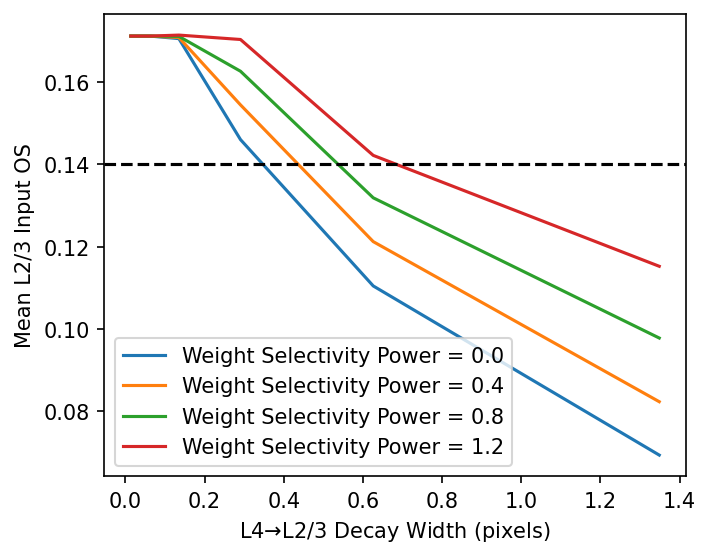

In [26]:
fig,axs = plt.subplots(1,1,figsize=(5,4),dpi=150)

for j,sel_pow in enumerate(sel_pows[::2]):
    axs.plot(arbor_facts*np.sqrt(sig2)*80,imap_OS_mean[:,2*j],label='Weight Selectivity Power = {:.1f}'.format(sel_pow))
axs.axhline(0.14,c='k',ls='--')
axs.legend()

axs.set_xlabel(r'L4$\to$L2/3 Decay Width (pixels)')
axs.set_ylabel('Mean L2/3 Input OS')

In [16]:
np.sqrt(sig2)*80

3.0157201754605385

In [1297]:
areaCVs = np.linspace(0,0.6,7)
sel_pows = np.linspace(0,1.4,8)
nseeds = 5

omap_OS = np.zeros((len(areaCVs),len(sel_pows)))
imap_OS = np.zeros((len(areaCVs),len(sel_pows)))

for i,areaCV in enumerate(areaCVs):
    for j,sel_pow in enumerate(sel_pows):
        for seed in range(nseeds):
            omap,imap = gen_maps(80,dens,bgnd_min,bgnd_max,maxOS,meanOS,seed,areaCV=areaCV,sel_pow=sel_pow)
            omap_OS[i,j] += np.mean(np.abs(omap))
            imap_OS[i,j] += np.mean(np.abs(imap))
        omap_OS[i,j] /= nseeds
        imap_OS[i,j] /= nseeds

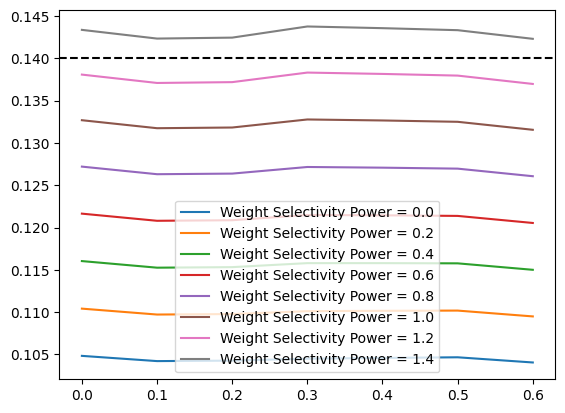

In [1299]:
fig,ax = plt.subplots(1,1)

for j,sel_pow in enumerate(sel_pows):
    ax.plot(areaCVs,imap_OS[:,j],label='Weight Selectivity Power = {:.1f}'.format(sel_pow))
ax.axhline(0.14,c='k',ls='--')
ax.legend()

(0.0, 1.0)

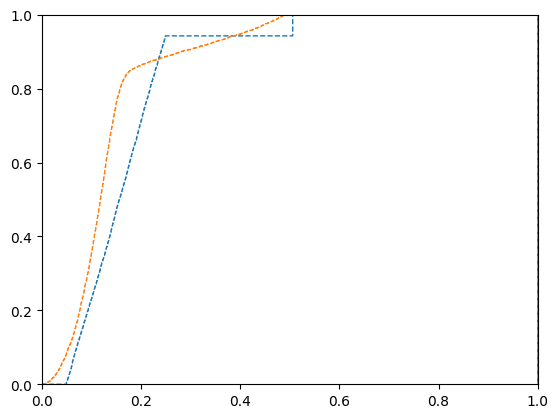

In [1242]:
plt.hist(np.abs(omap).flatten(),np.linspace(0,1,1001),density=True,cumulative=True,histtype='step',ls='--')
plt.hist(np.abs(imap).flatten(),np.linspace(0,1,1001),density=True,cumulative=True,histtype='step',ls='--')
plt.xlim(0,1)
plt.ylim(0,1)

In [1312]:
print(np.mean(np.abs(omap)))
print(np.mean(np.abs(imap)))

0.17111085
0.1253712478576359


# Construct On/Off Subregions

All selective RFs are found within $25^\circ$ of the center of the visual stimulus presentation screen. If we assume that this screen is centered with the fovea, then the average magnification factor for the ferret should be around 200 $\text{mm}^2$/$\text{deg}^2$. 80% of noise-filtered measured RFs show A conservative estimate for the arbor diameter 